# Tutorial - Big Data

## Tutorial 5

**Objetivo:** 
Que se familiaricen con la técnica de K-fold Cross Validation


In [1]:
import pandas as pd
import numpy as np
from ISLP import load_data

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Vamos a trabajar con la base 'Auto' de ISLP.

Tiene información para 392 vehículos. Kilometraje de gasolina, caballos de fuerza. El dataset tiene las siguiente variables:
- mpg: millas por galón
- cylinders: Número de cilindros entre 4 y 8
- displacement: Cilindrada o desplazamiento del motor (pulgadas cúbicas)
- horsepower: Caballos del motor
- weight: Peso del vehículo (libras)
- acceleration: Tiempo de aceleración de 0 a 100 km/h (seg.)
- year: Año del modelo (módulo 100)
- origin: Origen del vehículo (1. Americano, 2. Europeo, 3. Japonés)
- name: Nombre del vehículo

En este [link](https://islp.readthedocs.io/en/latest/datasets/Auto.html) tienen más información

In [2]:
auto = load_data("Auto")

# Dimensión de la base
print("Dimensión del dataframe:", auto.shape)

# Variables e información
#print(auto.dtypes)
print(auto.info())

auto.head()

Dimensión del dataframe: (392, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 27.6+ KB
None


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [3]:
# Hay duplicados?
print("Duplicados:", auto.duplicated().sum())

# Hay valores faltantes?
print("\n Missings:\n", auto.isnull().sum()) # conteo
#print(auto.isnull().mean() * 100) # como porcentaje

# No hay duplicados ni missing values

Duplicados: 0

 Missings:
 mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64


In [4]:
# Inspección rápida de las variables y sus valores
auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [5]:
auto["origin"].value_counts()

origin
1    245
3     79
2     68
Name: count, dtype: int64

In [6]:
# Notamos que origin es una variable categórica (toma valores 1, 2, 3)

# Usaremos one-hot encoding para transformar la columna categórica llamada origin 
# en varias columnas binarias (dummies).
# Cómo? get_dummies 
origin_dummies = pd.get_dummies(auto['origin'], prefix='origin')

# Concatenamos con el df original
auto_d = pd.concat([auto, origin_dummies], axis=1)
auto_d.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,origin_1,origin_2,origin_3
name,,,,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1,True,False,False
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1,True,False,False
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1,True,False,False
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1,True,False,False
ford torino,17.0,8,302.0,140,3449,10.5,70,1,True,False,False


Ahora vamos a trabajar con mpg como variable dependiente y horsepower como independiente

In [7]:
# Guardo los vectores de variable dependiente y de variable independiente respectivamente:
y = auto_d['mpg']
X = auto_d['horsepower']
X = np.array(X).reshape((-1, 1))

# Parto la base en dos y transformo el vector x: 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [8]:
# Regresión lineal
lreg=LinearRegression()
lreg.fit(x_train,y_train)
y_pred_lreg=lreg.predict(x_test)

print("R2:", r2_score(y_test,y_pred_lreg))

print("Coeficiente:", lreg.coef_)
y_pred_lreg = lreg.predict(x_test)
ecm_lreg = mean_squared_error(y_test, y_pred_lreg)
print('Error cuadrático medio (test):', ecm_lreg)

R2: 0.5956667983866822
Coeficiente: [-0.16090075]
Error cuadrático medio (test): 22.891996162101943


In [9]:
# Recordemos las Regresiones Polinómicas:
# Implican una transformación polinómica de las X, para luego implementar la regresión

# Veamos un modelo cuadrático:
poly = PolynomialFeatures(degree = 2, include_bias=False) 
# Recordar setear include_bias=False dado que en la regresión lineal -con LinearRegression- se incluirá la columna de 1s

#print(x_train)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)  
np.set_printoptions(suppress = True) # evita que el print salga con notación científica
print('X luego de la transformación:\n', x_train_poly[:5,])

# Ajustamos el modelo
model = LinearRegression().fit(x_train_poly, y_train) 
print('\nIntercepto:', model.intercept_)
print('Coeficientes:', model.coef_)

# Calculamos el Error Cuadrático Medio
y_pred_poly = model.predict(x_test_poly)
ecm2 = mean_squared_error(y_test, y_pred_poly)
print('Error cuadrático medio (test):', ecm2)

X luego de la transformación:
 [[  165. 27225.]
 [   71.  5041.]
 [  133. 17689.]
 [   60.  3600.]
 [  100. 10000.]]

Intercepto: 55.99491066376734
Coeficientes: [-0.44239775  0.00113262]
Error cuadrático medio (test): 16.606117867071884


In [10]:
# Veamos un modelo cúbico:
poly = PolynomialFeatures(degree = 3, include_bias=False) 

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)  
  
model = LinearRegression().fit(x_train_poly, y_train) 
y_pred_poly = model.predict(x_test_poly)

ecm3 = mean_squared_error(y_test, y_pred_poly)

print('\nIntercepto:', model.intercept_)
print('Coeficientes:', model.coef_)
print('Error cuadrático medio (test):', ecm3)


Intercepto: 53.254833211425016
Coeficientes: [-0.36805098  0.00051991  0.00000154]
Error cuadrático medio (test): 16.92426118524654


A priori, viendo el ECM, parecería que la regresión polinomial de grado 2 es la que mejor funciona 

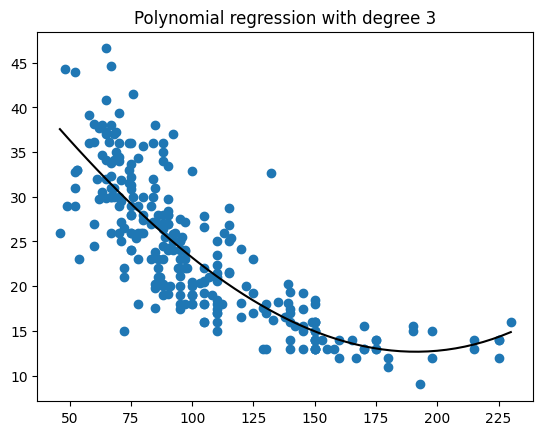

In [11]:
# Creamos un nuevo vector de X y aplicamos las transformaciones
X_seq = np.linspace(X.min(), X.max()).reshape(-1,1) 
# Valores entre el minimo y el maximo de X. 
# linspace por default crea 50 valores
# Aplicamos las transformaciones polinomicas
X_seq_poly = poly.fit_transform(X_seq)  

# Gráfico
plt.figure()
plt.scatter(x_train, y_train)
plt.plot(X_seq, model.predict(X_seq_poly),color="black")
plt.title("Polynomial regression with degree 3")
plt.show()

In [12]:
# Ahora supongamos que cambiamos la muestra y repetimos, hacemos lo mismo otra vez
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

# Qué error esperarían que obtengamos esta vez?
poly = PolynomialFeatures(degree = 3, include_bias=False) 

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)  
  
model = LinearRegression().fit(x_train_poly, y_train) 
y_pred_poly = model.predict(x_test_poly)

ecm3b = mean_squared_error(y_test, y_pred_poly)

print('\nIntercepto:', model.intercept_)
print('Coeficientes:', model.coef_)
print('Error cuadrático medio (test):', ecm3b)


Intercepto: 58.24966875687177
Coeficientes: [-0.49490922  0.00149141 -0.00000079]
Error cuadrático medio (test): 15.293069776610189


In [13]:
# Cómo podemos repetir el código sin escribirlo por tercera vez?
# Podemos hacer que nuestro código funcione para otros grados?

def transf_reg_poly(grado, x_train, x_test, y_train, y_test):
    '''
    La función realiza una transformación polinomial y luego corre una regresión lineal polinómica
    Input:
        grado
        x_train, x_test, y_train, y_test
    Output:
        modelo, ecm
    '''
    poly = PolynomialFeatures(degree = grado, include_bias=False) 

    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.fit_transform(x_test)  
  
    model = LinearRegression().fit(x_train_poly, y_train) 
    y_pred_poly = model.predict(x_test_poly)
    
    ecm = mean_squared_error(y_test, y_pred_poly)
    return model, ecm


In [14]:
ecm1 = transf_reg_poly(1, x_train, x_test, y_train, y_test)[1]
ecm2b = transf_reg_poly(2, x_train, x_test, y_train, y_test)[1]
ecm3b = transf_reg_poly(3, x_train, x_test, y_train, y_test)[1]
ecm4b = transf_reg_poly(4, x_train, x_test, y_train, y_test)[1]
ecm5b = transf_reg_poly(5, x_train, x_test, y_train, y_test)[1]

In [15]:
print('Regresión lineal:', ecm_lreg)
print('Grado2:', ecm2)
print('Grado3:', ecm3)

print('\nRegresión lineal:', ecm1)
print('Grado2:', ecm2b)
print('Grado3:', ecm3b)
print('Grado4:', ecm4b)
print('Grado5:', ecm5b)

Regresión lineal: 22.891996162101943
Grado2: 16.606117867071884
Grado3: 16.92426118524654

Regresión lineal: 21.372690058743164
Grado2: 15.358487806933855
Grado3: 15.293069776610189
Grado4: 15.327734379822102
Grado5: 14.653573215407992


Podemos concluir que la regresión lineal funciona peor, y que introducir un término cuadrático reduce el ECM. Pero en el caso de introducir un término cúbico, no es obvio si funciona mejor o no...

El ECM puede variar según qué observaciones quedaron incluidas en los sets de train y test

###  Nuevo enfoque: K-FOLD CROSS-VALIDATION  

Es un **técnica de remuestreo**. Se usa para estimar el error (test) asociado a un método de aprendizaje, para:  
- Elegir el nivel de complejidad optimo (Model selection)
- Evaluar el error de pronóstico fuera de la muestra (futura, condicional, contra fáctica, etc.) (Model Assesment)

Consiste en:
- Dividir las observaciones en k folds (pliegues), del mismo tamaño, aleatoriamente. 
- Ajustar el modelo k veces, cada vez con k-1 folds (distintos cada vez). Computar k veces el error de predicción en el fold reservado. (cada fold se usa k-1 veces como training set y 1 vez como test set).
- Estimar el error de predicción, estimación que surge de promediar las K estimaciones obtenidas.

Vamos a usar [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) de Scikitlearn

In [16]:
from IPython.display import Image, display

display(Image(url="https://global.discourse-cdn.com/dlai/optimized/3X/a/3/a3ed2de61c2b4fa00f1b7e939753e1a7e181afb0_2_690x476.png"
))

In [17]:
y = auto['mpg']
X = auto['horsepower']
X = np.array(X).reshape((-1, 1))

from sklearn.model_selection import KFold


Lo usual es usar K=5 o K=10

In [18]:
print(type(X), type(y))
print(X.shape, y.shape)
#print(X.flatten(), y)

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
(392, 1) (392,)


Una corrección para no contaminar los datos...

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)
print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)
#print(X_train, y_train)

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
(274, 1) (274,)


In [20]:
ecms = pd.DataFrame(columns=["grado", "particion", "ecm"])
ecms

K = 5

for grado in range(2, 10):   

    kf = KFold(n_splits = K, shuffle=True, random_state=100)
    
    # El método kf.split aplicado a X nos da los conjuntos de índices que necesitamos para
    # partir nuestros conjunto de datos en training y testing en cada iteración.
    #  OXXXX
    #  XOXXX
    #  XXOXX
    #  XXXOX
    #  XXXXO
    
    for i, (train_index2, val_index2) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index2], X_train[val_index2]
        y_train_fold, y_val_fold = y_train.iloc[train_index2], y_train.iloc[val_index2]
        #print(i, X_train_fold.shape[0])
        
        ecm = transf_reg_poly(grado, X_train_fold, X_val_fold, y_train_fold, y_val_fold)[1]

        new_row = pd.DataFrame({"grado": [grado], "particion": [i], "ecm": [ecm]})
        ecms = pd.concat([ecms, new_row], ignore_index=True)
            
ecms = ecms.astype({"grado":int, "particion":int})
ecms

C:\Users\pilih\AppData\Local\Temp\ipykernel_1332\1324378617.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ecms = pd.concat([ecms, new_row], ignore_index=True)


,grado,particion,ecm
0,2,0,21.285426
1,2,1,19.055554
2,2,2,15.178388
3,2,3,23.722474
4,2,4,25.858309
5,3,0,21.288901
6,3,1,19.213856
7,3,2,15.196739
8,3,3,23.847844
9,3,4,25.989880


#### Cómo elegir el modelo?

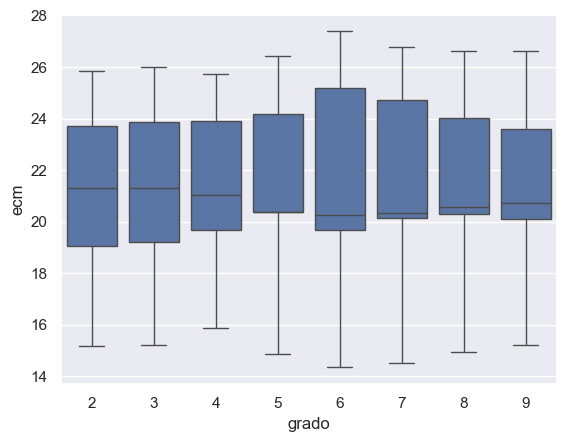

In [21]:
# Una opción: visualizar los ECMs en un boxplot
import seaborn as sns
sns.set()
ss = sns.boxplot(data=ecms, x="grado", y="ecm")


In [22]:
# Una opción para ver el mejor modelo sería sacar el error promedio para cada grado:
ecms_avg = ecms.groupby('grado').agg({'ecm':'mean'})
ecms_avg.reset_index(inplace = True)
ecms_avg.astype({"grado":int})
ecms_avg

,grado,ecm
0,2,21.020030
1,3,21.107444
2,4,21.238294
3,5,21.237590
4,6,21.366297
5,7,21.292665
6,8,21.283601
7,9,21.250373


In [23]:
# Función para seleccionar 
min_ecm = np.Inf
grado = None

for index, row in ecms_avg.iterrows():
    if row['ecm'] < min_ecm:
        min_ecm = row['ecm']
        grado = row['grado'].astype(int)

print('El mínimo error es', round(min_ecm, 2), 'y se da con un polinomio de grado', grado)

AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

In [ ]:
# Finalmente construimos el modelo polinomial de grado 2 y lo graficamos 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

modelo = transf_reg_poly(grado, x_train, x_test, y_train, y_test)[0]
ecm = transf_reg_poly(grado, x_train, x_test, y_train, y_test)[1]
        
X_seq = np.linspace(X.min(), X.max()).reshape(-1,1)
poly = PolynomialFeatures(degree = grado, include_bias=False) 
X_seq_poly = poly.fit_transform(X_seq)  

plt.figure()
plt.scatter(x_train, y_train)
plt.plot(X_seq, modelo.predict(X_seq_poly),color="black")
plt.title("Polynomial regression with degree {}".format(grado))
plt.show()
